In [1]:
from feos_pcsaft.dft import ExternalPotential, PcSaftFunctional, Adsorption1D, Geometry, Pore1D, State, Pore3D, Adsorption3D
from feos_pcsaft import PcSaftParameters
from feos_pcsaft.si import ANGSTROM, KELVIN, BAR, NAV, KILO, METER, MOL

import pandas as pd
import numpy as np
import os
import json
from scipy.spatial import Voronoi, distance
from itertools import permutations

In [2]:
class SolidStructure:

    N_atom = 0
    dimensions = {
        "Lx": 0.0,
        "Ly": 0.0,
        "Lz": 0.0
    }
    forcefield = ''
    total_mass = 0.0

    def __init__(self,structure):
 
        self.name = structure

        database = os.path.join(os.getcwd(),'structure_parameters','solid_database.json')
    
        with open(database) as f:
            data = json.load(f)

            for i in range(len(data)):
                if data[i]['Name']==self.name:
                    self.N_atom = data[i]['N_atom']
                    self.dimensions = data[i]['Dimensions']
                    self.forcefield = data[i]['Forcefield']
                    
                    
    def read_structure(self):
        struct_param = os.path.join(os.getcwd(),'structure_parameters')
        structure_df = pd.read_csv(os.path.join(struct_param,'{}.dat'.format(self.name)),names=['x','y','z','Type'], delim_whitespace=True)
        
        filename = os.path.join(struct_param,'{}.dat'.format(self.forcefield))
        forcefield_df = pd.read_csv(filename,names=['Type','sigma','epsilon','mass'], delim_whitespace=True)

        coordinates = np.array([structure_df["x"], structure_df["y"], structure_df["z"]])
        
        sigma_ss = np.zeros(len(structure_df["x"]))
        epsilon_k_ss = np.zeros_like(sigma_ss)
        
        for i in range(len(sigma_ss)):
            sigma_ss[i] = forcefield_df.sigma[forcefield_df.Type==structure_df["Type"][i]]
            epsilon_k_ss[i] = forcefield_df.epsilon[forcefield_df.Type==structure_df["Type"][i]]
        
        self.total_mass = np.sum(np.array([forcefield_df.mass[forcefield_df.Type==t]for t in structure_df.Type])) * 1.66054e-27

        return coordinates, sigma_ss, epsilon_k_ss   

In [3]:
coordinates.shape

NameError: name 'coordinates' is not defined

NameError: name 'coordinates' is not defined

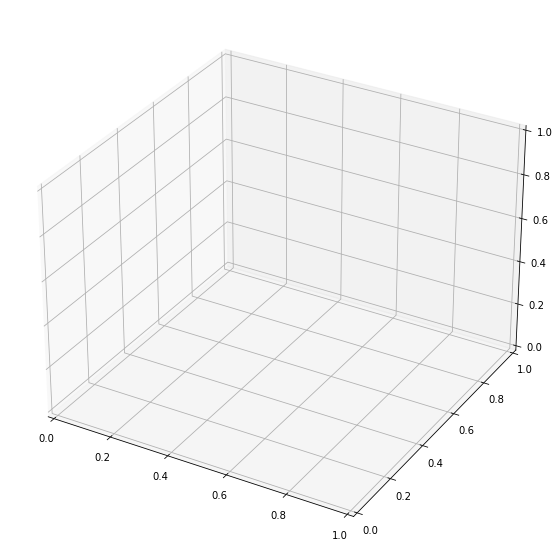

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=coordinates[0,:], ys=coordinates[1,:], zs=coordinates[2,:], marker='.')
plt.show()

In [6]:
structure = SolidStructure('LTA')
coordinates, sigma_ss, epsilon_ss = structure.read_structure()
system_size = [structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM, structure.dimensions["Lx"] * ANGSTROM]

In [6]:
params = PcSaftParameters.from_json(['argon'],'structure_parameters/noble_gases.json')
func = PcSaftFunctional(params)

In [7]:
print(f"system_size = {system_size}, pore_center = {pore_center},  pore_radius = {pore_radius}")

system_size = [4.7676 nm, 4.7676 nm, 4.7676 nm], pore_center = [5.9595, 5.9594999999999985, 5.9595],  pore_radius = 6.84534814234455


In [54]:
potential = ExternalPotential.FreeEnergyAveraged(coordinates * ANGSTROM, sigma_ss, epsilon_ss, pore_center, system_size, [51, 51])
# pore = Pore1D(func, Geometry.Spherical, 6.84534814234455 * ANGSTROM, potential, 128)
pore = Pore1D(func, Geometry.Spherical, 5.95 * ANGSTROM, potential, 64)

In [55]:
isotherm1D = Adsorption1D.adsorption_isotherm(func, 298.0 * KELVIN, (1.0e-3 * BAR, 10.0 * BAR, 11), pore)

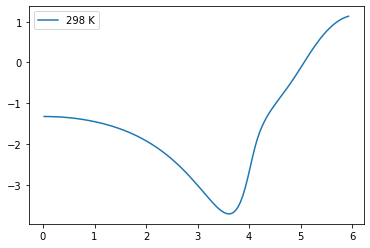

In [53]:
plt.plot(isotherm1D.profiles[0].z/ANGSTROM, isotherm1D.profiles[0].external_potential[0], label="298 K")
plt.legend()

In [34]:
pore3D = Pore3D(func, system_size, [64,64,64],coordinates* ANGSTROM, sigma_ss, epsilon_ss)

In [35]:
isotherm3D = Adsorption3D.adsorption_isotherm(func, 298.0 * KELVIN, (1.0e-3 * BAR, 9.0 * BAR, 5), pore3D)

In [43]:
isotherm1D.total_adsorption*NAV*64

array([1.11187693e-02, 1.09395170e+01, 2.14921005e+01, 3.16744990e+01,
       4.14946631e+01, 5.09622886e+01, 6.00883403e+01, 6.88846607e+01,
       7.73636506e+01, 8.55380098e+01, 9.34205315e+01])

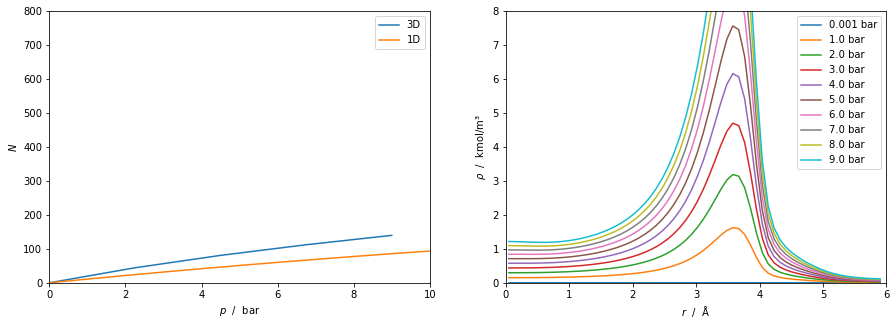

In [56]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(isotherm3D.pressure/BAR, isotherm3D.total_adsorption*NAV, label="3D")
ax[0].plot(isotherm1D.pressure/BAR, isotherm1D.total_adsorption*NAV*64, label="1D")
ax[0].set_xlabel('$p~~/~~\\mathrm{bar}$')
ax[0].set_ylabel('$N$')
ax[0].legend()
ax[0].set_xlim(0,10)
ax[0].set_ylim(0,800)

for profile in isotherm1D.profiles[:10]:
    ax[1].plot(profile.r/ANGSTROM, (profile.density/(KILO*MOL/METER**3)).T, label=f'{profile.bulk.pressure()/BAR:.2} bar')
ax[1].set_xlabel('$r~~/~~\\mathrm{\AA}$')
ax[1].set_ylabel('$\\rho~~/~~\\mathrm{kmol/m³}$')
ax[1].set_xlim(0,6)
ax[1].set_ylim(0,8)
ax[1].legend()

## plt.plot(isotherm3D.profiles[-1].x/ANGSTROM, (isotherm3D.profiles[-1].density/(KILO*MOL/METER**3))[0,30,30,:])

In [57]:
import scipy.integrate as spin

spin.trapezoid(isotherm1D.profiles[-1].density*NAV*ANGSTROM**3 *4*3.141*(isotherm1D.profiles[-1].z/ANGSTROM) **2,isotherm1D.profiles[-1].z/ANGSTROM )*64

array([93.38036118])